# TM10007 Assignment template -- ECG data

## Imports

In [1]:
import zipfile
import os
import pandas as pd
import numpy as np
import time

from scipy.stats import normaltest
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV

from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

## Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
#from sklearn import svm
from sklearn.svm import SVC
from xgboost import XGBClassifier

## Ensembling
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

## Data loading and cleaning

Load the dataset

In [2]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

with zipfile.ZipFile('/content/tm10007_ml/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

Cloning into 'tm10007_ml'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 87 (delta 9), reused 8 (delta 8), pack-reused 72 (from 1)
Receiving objects: 100% (87/87), 67.99 MiB | 14.45 MiB/s, done.
Resolving deltas: 100% (31/31), done.
The number of samples: 827
The number of columns: 9001


## Split data into training and test set

In [3]:
label = data['label']

# Split the data into training and test set
train, test = train_test_split(data, test_size=0.2, random_state=42, stratify=label)

## Pre-processing

Separate labels

In [4]:
# Check what label is normal and abnormal
if sum(data['label']) > len(data) / 2: # Biggest class is normal
    normal_data = data[label == 0]
    abnormal_data = data[label == 1]
else:
    normal_data = data[label == 1]
    abnormal_data = data[label == 0]

# Split train data into label and data
label_train = train['label']
data_train = train.drop('label', axis=1)

Missing data handling

In [5]:
# change None into 0
data_train_clean = data_train.copy()
imputer = SimpleImputer(strategy='constant', fill_value=0)
data_train_clean[:] = imputer.fit_transform(data_train_clean)

# check how many zeros are in the dataframe and how they are distributed over the rows
total_zeros = (data_train == 0).sum().sum()
print("Total number of zeros:", total_zeros)

rows_with_zeros = (data_train == 0).any(axis=1).sum()
print("Number of rows with at least one zero:", rows_with_zeros)

zero_counts_per_row = (data_train == 0).sum(axis=1)
rows_with_zeros = zero_counts_per_row[zero_counts_per_row > 0]
print("Rows with their zero count: ", rows_with_zeros)

# remove rows with more than 5% zeros
threshold = 0.05 * data_train.shape[1]    # threshold = 5% of total columns
rows_to_keep = zero_counts_per_row[zero_counts_per_row <= threshold].index
filtered_data_train = data_train.loc[rows_to_keep]
filtered_label_train = label_train[label_train.index.isin(rows_to_keep)].reset_index(drop=True)

Total number of zeros: 10500
Number of rows with at least one zero: 14
Rows with their zero count:  385    750
251    750
575    750
269    750
323    750
537    750
177    750
321    750
446    750
790    750
434    750
601    750
784    750
542    750
dtype: int64


Define inner cross-validation

In [6]:
# K-fold cross-validation
n_folds = 2
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

Scaling

In [7]:
# Check for normal distribution of features
p_values = filtered_data_train.apply(lambda col: normaltest(col)[1])
non_normal_features = (p_values < 0.05).sum() # a p-value > 0.05 means it is not normally distributed
print(f'Number of not normal distributed features: {non_normal_features} van {len(filtered_data_train.columns)}')

# Find outliers in data
def count_outliers(df):
  '''function to detect outliers in data'''
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = ((df < lower_bound) | (df > upper_bound)).sum()
  return outliers

outlier_counts = count_outliers(filtered_data_train)
mean_outliers = outlier_counts.mean()
features_with_many_outliers = (outlier_counts > 0.1 * len(filtered_data_train.index)).sum()
print(f'Number of features with >10% outliers: {features_with_many_outliers}')

# Robust scaler chosen: based on normal distribution and outliers
scaler = RobustScaler()
data_scaled = scaler.fit_transform(filtered_data_train)
data_scaled = pd.DataFrame(data_scaled, columns=filtered_data_train.columns, index=filtered_data_train.index)

Number of not normal distributed features: 9000 van 9000
Number of features with >10% outliers: 525


## Feature selection and extraction

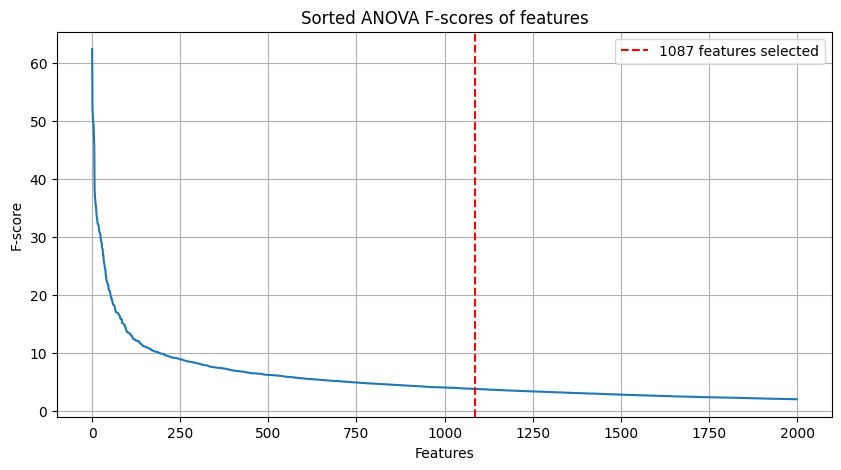

Univariatiate statistical feature selection performed: 1087 features selected.


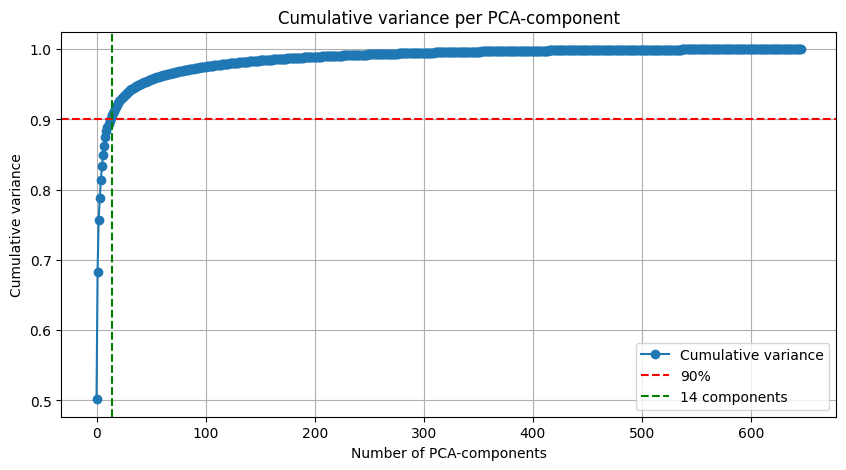

PCA feature selection performed: 14 features left.


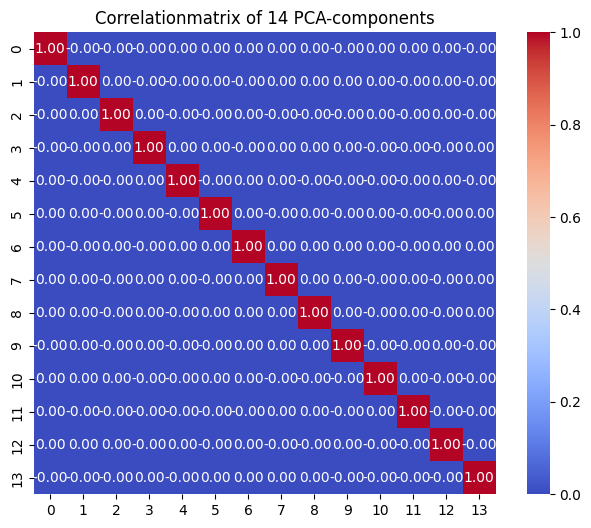

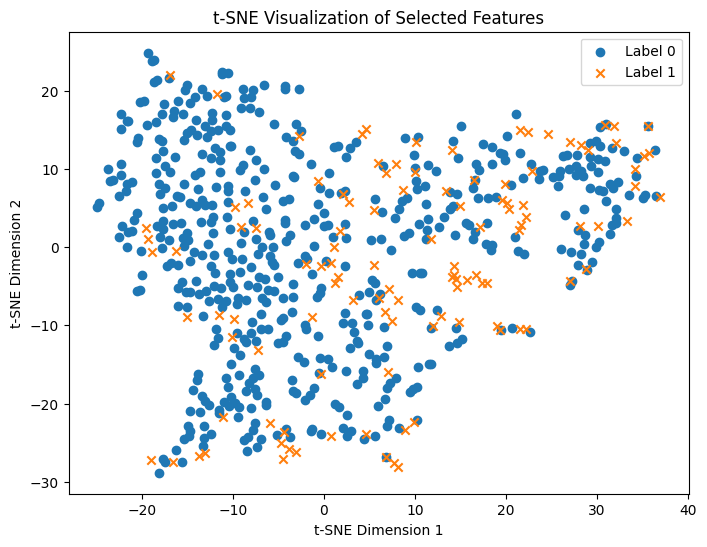

In [8]:
# 1. Feature selection using univariate statistical testing: ANOVA f-test
# Number of features for p < 0.05
f_scores, p_values = f_classif(data_scaled, filtered_label_train)
sorted_scores = np.sort(f_scores)[::-1]  # Sort descending
k_best = np.sum(p_values < 0.05) # Only features with p_value < 0.05

# Visualize f-scores
plt.figure(figsize=(10,5))
plt.plot(sorted_scores[:2000])
plt.axvline(x=k_best, color='r', linestyle='--', label=f'{k_best} features selected')
plt.title('Sorted ANOVA F-scores of features')
plt.xlabel('Features')
plt.ylabel('F-score')
plt.legend()
plt.grid(True)
plt.show()

selector = SelectKBest(f_classif, k=k_best) # Select top features
data_selected = selector.fit_transform(data_scaled, filtered_label_train) # Fit to the training data

# Get the feature names
selected_feature_indices = selector.get_support(indices=True)  # Get indices of selected features
selected_feature_names = data_scaled.columns[selector.get_support()] # Data is pandas dataframe
data_selected = pd.DataFrame(data_selected, columns=selected_feature_names, index=data_scaled.index)

print(f'Univariatiate statistical feature selection performed: {k_best} features selected.')

# 2. Dimensionality reduction using PCA
# Number of components for ≥90% variance
pca_full = PCA().fit(data_selected)
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)
pca_components = np.argmax(cumulative_var >= 0.90) + 1

# Plot variance
plt.figure(figsize=(10,5))
plt.plot(cumulative_var, marker='o', label='Cumulative variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90%')
plt.axvline(x=pca_components, color='g', linestyle='--', label=f'{pca_components} components')
plt.title('Cumulative variance per PCA-component')
plt.xlabel('Number of PCA-components')
plt.ylabel('Cumulative variance')
plt.legend()
plt.grid(True)
plt.show()

pca = PCA(n_components=pca_components)  # Reduce to features so that variance > 0.9
data_pca_selected = pca.fit_transform(data_selected) # Fit to the training data
data_pca_selected = pd.DataFrame(data_pca_selected, index=data_selected.index)

print(f'PCA feature selection performed: {pca_components} features left.')

# Correlation matrix of PCA-components
plt.figure(figsize=(8,6))
sns.heatmap(data_pca_selected.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title(f'Correlationmatrix of {pca_components} PCA-components')
plt.show()

# 3. Visualize new features with t-SNE
tsne = TSNE(n_components=2, random_state=42) # Reduce to 2 dimensions for plotting
data_tsne = tsne.fit_transform(data_pca_selected)

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_tsne[filtered_label_train == 0, 0], data_tsne[filtered_label_train == 0, 1], label='Label 0', marker='o')  # Plot points for label 0
plt.scatter(data_tsne[filtered_label_train == 1, 0], data_tsne[filtered_label_train == 1, 1], label='Label 1', marker='x')  # Plot points for label 1
plt.legend()  # Add a legend to identify the labels
plt.title('t-SNE Visualization of Selected Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# **Classify**

Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters for SGDClassifier: {'alpha': 0.01, 'loss': 'log_loss', 'penalty': 'l2'}
Fitting 2 folds for each of 14 candidates, totalling 28 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best parameters for SVC: {'C': 1, 'coef0': 0.0, 'kernel': 'linear'}
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best parameters for RandomForestClassifier: {'max_depth': 7, 'n_estimators': 10}
Fitting 2 folds for each of 27 candidates, totalling 54 fits
Best parameters for SGDClassifier: {'alpha': 0.1, 'loss': 'log_loss', 'penalty': 'l2'}
Fitting 2 folds for each of 14 candidates, totalling 28 fits
Best parameters for KNeighborsClassifier: {'n_neighbors': 2, 'weights': 'distance'}
Fitting 2 folds for each of 36 candidates, totalling 72 fits
Best parameters for SVC: {'C': 1, 'coef0': 0.0, 'kernel': 'linear'}
Fitting 2 fol

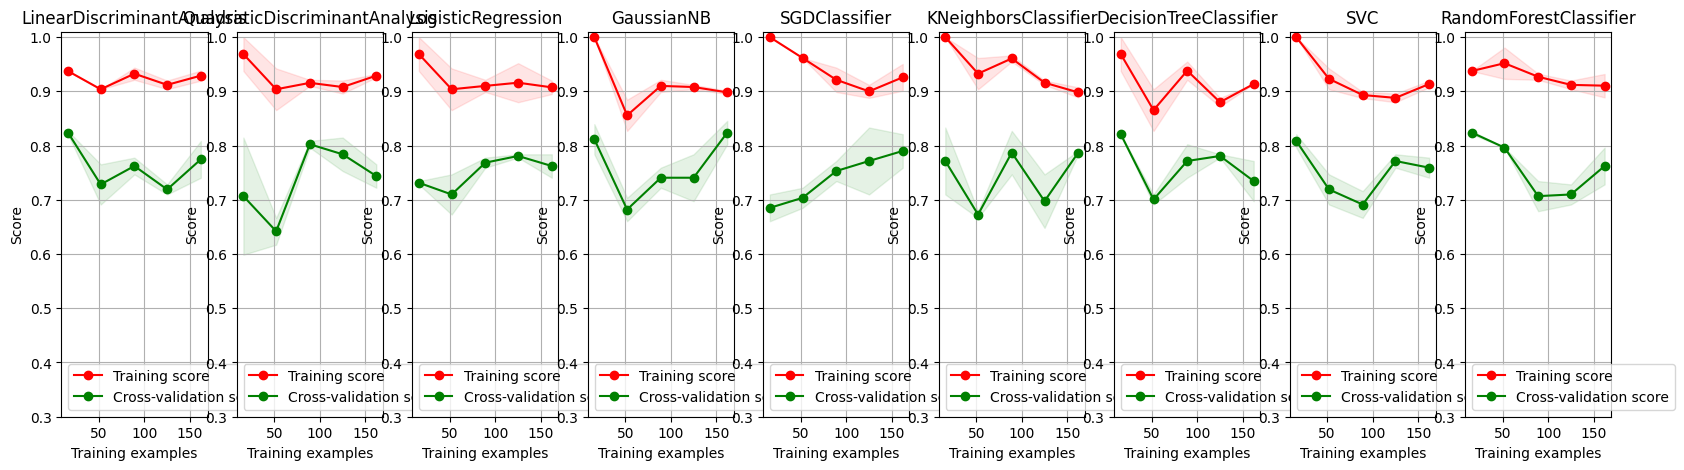

In [9]:
classifiers = {
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(),
    "LogisticRegression": LogisticRegression(),
    "GaussianNB": GaussianNB(),
    "SGDClassifier": SGDClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "SVC": SVC(),
    "RandomForestClassifier": RandomForestClassifier(),
}

# Hyperparameters per classifier
# param_grids = {
#     "SGDClassifier": {"loss": ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
#                       "penalty": ['l2', 'l1', 'elasticnet'], "alpha": [0.0001, 0.001, 0.01, 0.1]},
#     "KNeighborsClassifier": {"n_neighbors": [3, 5, 7, 9, 11, 15], "weights": ['uniform', 'distance']},
#     "DecisionTreeClassifier": {"max_depth": [3, 5, 7, 9, 11, 15], "min_samples_split": [2, 5, 10, 15, 20]},
#     "SVC": {"kernel": ['linear', 'rbf', 'poly', 'sigmoid'], "C": [0.1, 1, 10, 100], "degree": [2, 3, 4],
#             "gamma": ['scale', 'auto'], "coef0": [0.0, 0.1, 0.2, 0.3]},
#     "RandomForestClassifier": {"n_estimators": [1, 5, 10, 50, 100, 200], "max_depth": [3, 5, 7, 9, 11, 15],
#                                "min_samples_split": [2, 5, 10, 15, 20]}
# }
param_grids = {
    "SGDClassifier": {"loss": ['hinge', 'log_loss', 'modified_huber'], "penalty": ['l2', 'l1', 'elasticnet'],
                      "alpha": [0.001, 0.01, 0.1]},
    "KNeighborsClassifier": {"n_neighbors": [2, 3, 5, 7, 9, 11, 15], "weights": ['uniform', 'distance']},
    "SVC": {"kernel": ['linear', 'rbf', 'poly', 'sigmoid'], "C": [0.1, 1, 10],
            "coef0": [0.0, 0.15, 0.3]},
    "RandomForestClassifier": {"n_estimators": [1, 5, 10, 50, 100, 200], "max_depth": [3, 5, 7, 9, 11, 15]}
}

best_params = {}

auc_scores = {}
f1_scores = {}
acc_scores = {}
fig, axes = plt.subplots(1, len(classifiers), figsize=(20, 5))

i=0

ensemble_classifiers = []
f1_threshold = 0.35

for train_index, val_index in cv.split(filtered_data_train, filtered_label_train):
    # split data into train and validation for this fold
    X_train, X_val = filtered_data_train.iloc[train_index], filtered_data_train.iloc[val_index]
    y_train, y_val = filtered_label_train.iloc[train_index], filtered_label_train.iloc[val_index]

    # scaling
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # feature selection
    # univariate statistical selection
    selector = SelectKBest(f_classif, k=k_best)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_val_selected = selector.transform(X_val_scaled)

    # PCA
    pca = PCA(n_components=pca_components)
    pca.fit(X_train_selected, y_train)
    X_train_final_selected = pca.transform(X_train_selected)
    X_val_final_selected = pca.transform(X_val_selected)

    # Store classifiers for ensembling
    fold_classifiers = []

    for clf_name,clf in classifiers.items():
      auc_scores.setdefault(clf_name, [])
      auc_scores.setdefault('VotingEnsembleHard', [])
      f1_scores.setdefault(clf_name, [])
      f1_scores.setdefault('VotingEnsembleHard', [])
      acc_scores.setdefault(clf_name, [])
      acc_scores.setdefault('VotingEnsembleHard', [])

      # inner loop for hyperparameter optimization
      if clf_name in param_grids:
            grid_search = GridSearchCV(clf, param_grids[clf_name], cv=cv, n_jobs=-1, scoring='f1', verbose=1)
            grid_search.fit(X_train_final_selected, y_train)
            clf = grid_search.best_estimator_
            best_params[clf_name] = grid_search.best_params_
            print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
      else:
            clf.fit(X_train_final_selected, y_train)

      # train the classifier on the selected features
      #clf.fit(X_train_final_selected, y_train)

      # Calculate accuracy for this classifier
      y_pred = clf.predict(X_val_final_selected)
      acc = accuracy_score(y_val, y_pred)
      acc_scores[clf_name].append(acc)

      # Calculate AUC for this classifier
      if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_val_final_selected)[:, 1]
        auc = metrics.roc_auc_score(y_val, y_score)
      else:
            try:
                y_score = clf.decision_function(X_val_final_selected)
                auc = metrics.roc_auc_score(y_val, y_score)
            except AttributeError:
                y_score = y_pred
                auc = metrics.roc_auc_score(y_val, y_score)

      auc_scores[clf_name].append(auc)  # Store AUC for this classifier

      # Calculate F1-score for this classifier
      f1 = metrics.f1_score(y_val, y_pred)
      f1_scores[clf_name].append(f1)  # Store F1-score for this classifier

      # Store high scoring classifiers
      if f1 > f1_threshold:
        fold_classifiers.append((clf_name, clf))

    if len(fold_classifiers) > 1:  # Cannot ensemble 1 classifier
      voting_ensemble = VotingClassifier(estimators=fold_classifiers, voting='hard')
      voting_ensemble.fit(X_train_final_selected, y_train)
      # Calculate performance metrics for the ensemble
      y_pred = voting_ensemble.predict(X_val_final_selected)
      acc = accuracy_score(y_val, y_pred)
      acc_scores['VotingEnsembleHard'].append(acc)

      # Calculate AUC for the ensemble
      if hasattr(voting_ensemble, "predict_proba"):
        y_score = voting_ensemble.predict_proba(X_val_final_selected)[:, 1]
        auc = metrics.roc_auc_score(y_val, y_score)
      else:
            try:
                y_score = voting_ensemble.decision_function(X_val_final_selected)
                auc = metrics.roc_auc_score(y_val, y_score)
            except AttributeError:
                y_score = y_pred
                auc = metrics.roc_auc_score(y_val, y_score)

      auc_scores['VotingEnsembleHard'].append(auc)

      # Calculate F1-score for ensemble
      f1 = metrics.f1_score(y_val, y_pred)
      f1_scores['VotingEnsembleHard'].append(f1)
      if f1 > f1_threshold:
        ensemble_classifiers.append(voting_ensemble)

for clf_name in classifiers:
    avg_auc = np.mean(auc_scores[clf_name])
    avg_f1 = np.mean(f1_scores[clf_name])
    avg_acc = np.mean(acc_scores[clf_name])
    print(f"Classifier: {clf_name}")
    print(f"Average AUC: {avg_auc}")
    print(f"Average F1-score: {avg_f1}")
    print(f"Average Accuracy: {avg_acc}")

    # Learning curve plotting
    axes[i].set_title(clf_name)
    axes[i].set_ylim(0.3, 1.01)  # Adjust ylim as needed
    axes[i].set_xlabel("Training examples")
    axes[i].set_ylabel("Score")

    train_sizes, train_scores, val_scores = \
      learning_curve(clf, X_train_final_selected, y_train,
                      cv=cv,n_jobs=4, train_sizes=np.linspace(0.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    axes[i].grid()
    axes[i].fill_between(train_sizes,train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes[i].fill_between(train_sizes,val_scores_mean - val_scores_std,val_scores_mean + val_scores_std,alpha=0.1,color="g")
    axes[i].plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes[i].plot(train_sizes, val_scores_mean, "o-", color="g",
                label="Cross-validation score")
    axes[i].legend(loc="best")

    i += 1



#def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#  axes.set_title(title)
#     if ylim is not None:
#         axes.set_ylim(*ylim)
#     axes.set_xlabel("Training examples")
#     axes.set_ylabel("Score")

#     train_sizes, train_scores, test_scores  = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     # Plot learning curve
#     axes.grid()
#     axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes.legend(loc="best")

#     return plt

# # First make plot without classifiers:
# num = 0
# fig = plt.figure(figsize=(24,8*len(clsfs)))
# for X, Y in zip(Xs, Ys):
#     ax = fig.add_subplot(7, 3, num + 1)
#     ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
#         s=25, edgecolor='k', cmap=plt.cm.Paired)
#     num += 1


# # Create a cross-validation object
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

# # Now use the classifiers on all datasets
# for clf in clsfs:
#     for X, Y in zip(Xs, Ys):
#         # Split data in training and testing
#         title = str(type(clf))
#         ax = fig.add_subplot(7, 3, num + 1)
#         plot_learning_curve(clf, title, X, Y, ax, ylim=(0.3, 1.01), cv=cv)
#         num += 1


In [10]:
print(best_params)

f1_avg = {}
score = 0

for clf_name in classifiers:
  f1_avg[clf_name] = np.mean(f1_scores[clf_name])
  if score < f1_avg[clf_name]:
    score = f1_avg[clf_name]
    best_clf = clf_name
print(best_clf)
print(score)

{'SGDClassifier': {'alpha': 0.1, 'loss': 'log_loss', 'penalty': 'l2'}, 'KNeighborsClassifier': {'n_neighbors': 2, 'weights': 'distance'}, 'SVC': {'C': 1, 'coef0': 0.0, 'kernel': 'linear'}, 'RandomForestClassifier': {'max_depth': 7, 'n_estimators': 1}}
SGDClassifier
0.3982060909470171


## Performance Metrics

In [ ]:
#   # Get prediction scores (if available) for AUC calculation
# clfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(),
#         LogisticRegression(), GaussianNB(), SGDClassifier(),
#         KNeighborsClassifier(), DecisionTreeClassifier(),
#         svmlin, svmrbf, svmpoly, svmsig]

# for clf in clfs:  # Iterate through each classifier
#     clf.fit(data_train, label_train)
#     y_pred = clf.predict(data_train)

#     if hasattr(clf, 'predict_proba'):
#         y_score = clf.predict_proba(data_train)[:, 1]
#     else:
#         y_score = y_pred

#     # Calculate metrics for the current classifier inside the loop
#     auc = metrics.roc_auc_score(label_train, y_score)
#     f1 = metrics.f1_score(label_train, y_pred)

#     # Print the results for the current classifier
#     print(f"Classifier: {clf.__class__.__name__}")
#     print("AUC:", auc)
#     print("F1-score:", f1)

## Evaluate model

In [ ]:
# Split test data into label and data
label_test = test['label']
data_test = test.drop('label', axis=1)